/var/folders/0r/rzm5lkxs6r763lxm3q26yh7h0000gn/T/ipykernel_46181/232365456.py:92: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reco_centroids["geometry"] = reco_centroids.geometry.centroid


✅ EV-to-charger improvement (state, plugs-based): 18.2 → 11.0
🗺️  Combined map saved as output/final_combined_map.html


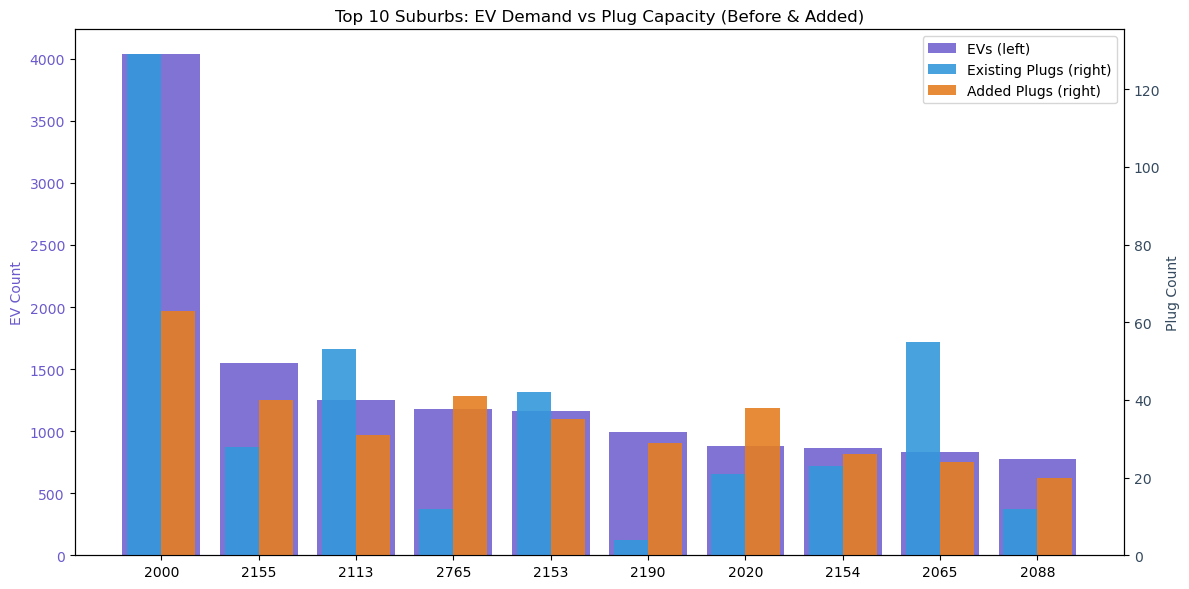

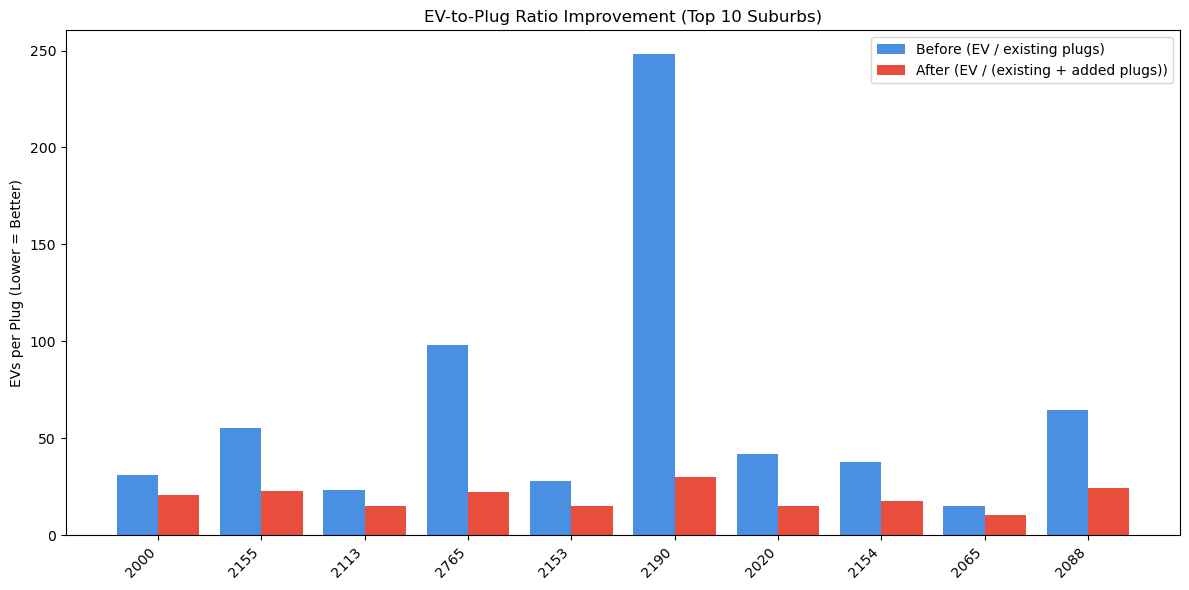

/var/folders/0r/rzm5lkxs6r763lxm3q26yh7h0000gn/T/ipykernel_46181/232365456.py:232: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="POA_CODE", y="plugs_future", palette="coolwarm")


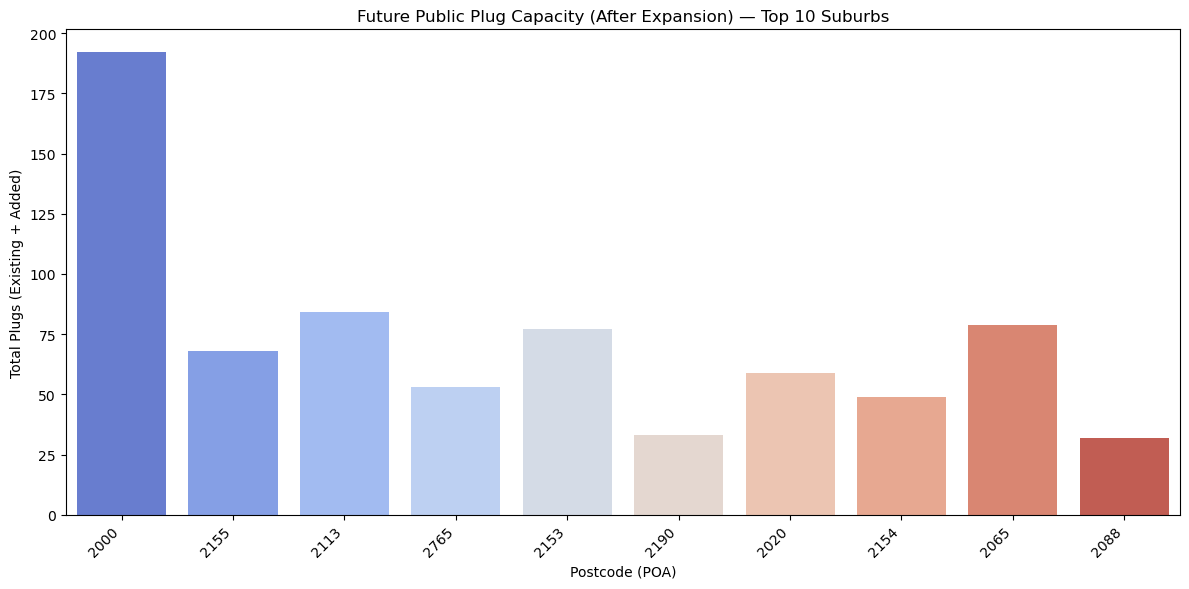

In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt

# ================================
# FILE PATHS
# ================================
POA_FILE = "output/stages/06_poa_demographics_summary.csv"   # authoritative EV + plugs
RECOMMENDED_CSV = "output/grid_ml/recommended_candidates.csv" # grid output with WKT + pred_plugs/final_score
CHARGER_FILE = "output/stages/02_chargers_active_sample.csv"  # point locations (for map only)
POA_SHP = "/Users/yangfeng/Desktop/bootcamp/capstone project/POA_2021_AUST_GDA2020.shp"

# ================================
# LOAD DATA
# ================================
poa_attrs = pd.read_csv(POA_FILE)      # has POA_CODE (or POA_CODE21), ev_count, total_plugs, ev_to_charger_ratio, etc.
reco = pd.read_csv(RECOMMENDED_CSV)
chargers = pd.read_csv(CHARGER_FILE)

# --- Load POA polygons (authoritative geometry) ---
poa_poly = gpd.read_file(POA_SHP).to_crs(4326)

# Normalise POA code column name to 'POA_CODE'
if "POA_CODE" in poa_attrs.columns:
    pass
elif "POA_CODE21" in poa_attrs.columns:
    poa_attrs = poa_attrs.rename(columns={"POA_CODE21": "POA_CODE"})
elif "pcode" in poa_attrs.columns:
    poa_attrs = poa_attrs.rename(columns={"pcode": "POA_CODE"})
else:
    raise ValueError("Could not find POA code column in POA_FILE.")

# Normalise POA codes to 4-digit strings
poa_attrs["POA_CODE"] = poa_attrs["POA_CODE"].astype(str).str.split(".").str[0].str.zfill(4)

# Polygons: ensure POA_CODE21 available then normalise to 'POA_CODE'
if "POA_CODE21" not in poa_poly.columns:
    raise ValueError("POA shapefile must contain 'POA_CODE21'.")
poa_poly["POA_CODE"] = poa_poly["POA_CODE21"].astype(str).str.zfill(4)

# NSW filter via ranges
poa_poly["POA_INT"] = pd.to_numeric(poa_poly["POA_CODE"], errors="coerce")
nsw_mask = (
    poa_poly["POA_INT"].between(1000, 2599) |
    poa_poly["POA_INT"].between(2620, 2899) |
    poa_poly["POA_INT"].between(2921, 2999)
)
poa_poly = poa_poly.loc[nsw_mask].copy()
poa_poly = poa_poly.drop(columns=["POA_INT"])

# ================================
# PREPARE GEO DATAFRAMES
# ================================
# Recommended grid polygons (WKT -> geometry)
reco_gdf = reco.copy()
reco_gdf["geometry"] = reco_gdf["geometry"].apply(wkt.loads)
reco_gdf = gpd.GeoDataFrame(reco_gdf, geometry="geometry", crs="EPSG:4326")

# Charger geodataframe (for map only)
lat_col = next((c for c in chargers.columns if "lat" in c.lower()), None)
lon_col = next((c for c in chargers.columns if "lon" in c.lower()), None)
if not lat_col or not lon_col:
    raise ValueError("Could not detect latitude/longitude columns in chargers CSV.")
chargers_gdf = gpd.GeoDataFrame(
    chargers,
    geometry=gpd.points_from_xy(chargers[lon_col], chargers[lat_col]),
    crs="EPSG:4326"
)

# ================================
# MERGE AUTHORITATIVE EV/PLUGS & ADD PREDICTED PLUGS BY POA
# ================================
# Start from authoritative POA attributes (EV + existing plugs)
keep_cols = ["POA_CODE", "ev_count", "total_plugs", "ev_proportion"]
if "ev_to_charger_ratio" in poa_attrs.columns:
    keep_cols.append("ev_to_charger_ratio")
if "need_score" in poa_attrs.columns:
    keep_cols.append("need_score")

poa_summary = poa_attrs[keep_cols].copy()
# Fill basics
poa_summary["ev_count"] = poa_summary["ev_count"].fillna(0).astype(int)
poa_summary["total_plugs"] = poa_summary["total_plugs"].fillna(0).astype(int)

# Assign recommended polygons to POA via centroids, then sum predicted plugs per POA
reco_centroids = reco_gdf.copy()
reco_centroids["geometry"] = reco_centroids.geometry.centroid

reco_join = gpd.sjoin(
    reco_centroids[["geometry", "pred_plugs"]],
    poa_poly[["POA_CODE", "geometry"]],
    how="left",
    predicate="within"
)

pred_add = (
    reco_join.dropna(subset=["POA_CODE"])
             .groupby("POA_CODE")["pred_plugs"]
             .sum()
             .rename("pred_plugs_added")
             .reset_index()
)

# Merge added plugs into POA summary
poa_summary = poa_summary.merge(pred_add, on="POA_CODE", how="left").fillna({"pred_plugs_added": 0})
poa_summary["pred_plugs_added"] = poa_summary["pred_plugs_added"].round().astype(int)

# Compute BEFORE/AFTER plugs & ratios (plugs-based)
poa_summary["plugs_before"] = poa_summary["total_plugs"]
poa_summary["plugs_after"] = poa_summary["total_plugs"] + poa_summary["pred_plugs_added"]

poa_summary["ratio_before"] = np.where(
    poa_summary["plugs_before"] > 0,
    poa_summary["ev_count"] / poa_summary["plugs_before"],
    np.nan
)
poa_summary["ratio_after"] = np.where(
    poa_summary["plugs_after"] > 0,
    poa_summary["ev_count"] / poa_summary["plugs_after"],
    np.nan
)

# State-level ratio (plugs-based)
total_ev = poa_summary["ev_count"].sum()
total_plugs_before = poa_summary["plugs_before"].sum()
total_plugs_after  = poa_summary["plugs_after"].sum()
ratio_before_state = total_ev / max(total_plugs_before, 1)
ratio_after_state  = total_ev / max(total_plugs_after, 1)
print(f"✅ EV-to-charger improvement (state, plugs-based): {ratio_before_state:.1f} → {ratio_after_state:.1f}")

# Save a CSV for inspection (optional)
poa_summary.to_csv("output/poa_summary_plugs_based.csv", index=False)

# ================================
# MAP (existing points + recommended sites)
# ================================
m = folium.Map(location=[-33.86, 151.21], zoom_start=10, tiles="CartoDB positron")

# Colour map for recommended chargers by predicted plugs
if "pred_plugs" in reco_gdf.columns and len(reco_gdf) > 0:
    colormap = cm.linear.YlOrRd_09.scale(reco_gdf["pred_plugs"].min(), reco_gdf["pred_plugs"].max())
    colormap.caption = "Recommended Capacity (Predicted Plugs)"
    colormap.add_to(m)

# EXISTING chargers – blue
for _, row in chargers_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.85,
        popup="Existing Public Charger"
    ).add_to(m)

# RECOMMENDED sites – coloured by predicted plugs
for _, row in reco_gdf.iterrows():
    c = row.geometry.centroid
    fill_color = "#e67e22"
    if "pred_plugs" in row and pd.notnull(row["pred_plugs"]) and 'colormap' in locals():
        fill_color = colormap(row["pred_plugs"])
    folium.CircleMarker(
        location=[c.y, c.x],
        radius=6,
        color=None,
        fill=True,
        fill_opacity=0.9,
        fill_color=fill_color,
        popup=f"Recommended Site<br>Predicted plugs: {row.get('pred_plugs', '–')}<br>Score: {row.get('final_score', np.nan):.2f}"
    ).add_to(m)

folium.LayerControl().add_to(m)
m.save("output/final_combined_map.html")
print("🗺️  Combined map saved as output/final_combined_map.html")

# ================================
# PLOTS (Top 10 by EV count) — PLUGS-BASED
# ================================
top10 = poa_summary.sort_values("ev_count", ascending=False).head(10).copy()

# Plot 1: EV Demand vs Plugs (dual axis: EVs vs plugs before/added)
plt.figure(figsize=(12, 6))
x = np.arange(len(top10))
ax1 = plt.gca()
bars1 = ax1.bar(x, top10["ev_count"], color="#6a5acd", alpha=0.85, label="EVs (left)")
ax1.set_ylabel("EV Count", color="#6a5acd")
ax1.tick_params(axis='y', labelcolor="#6a5acd")

ax2 = ax1.twinx()
w = 0.35
bars2 = ax2.bar(x - w/2, top10["plugs_before"], width=w, color="#3498db", alpha=0.9, label="Existing Plugs (right)")
bars3 = ax2.bar(x + w/2, top10["pred_plugs_added"], width=w, color="#e67e22", alpha=0.9, label="Added Plugs (right)")
ax2.set_ylabel("Plug Count", color="#34495e")
ax2.tick_params(axis='y', labelcolor="#34495e")

plt.xticks(x, top10["POA_CODE"], rotation=45, ha="right")
plt.title("Top 10 Suburbs: EV Demand vs Plug Capacity (Before & Added)")
lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines += L[0]; labels += L[1]
plt.legend(lines, labels, loc="upper right")
plt.tight_layout()
plt.savefig("output/top10_ev_vs_plugs_dual_axis.png", dpi=300)
plt.show()

# Plot 2: EV-to-Charger Ratio Improvement (Before vs After; plugs-based)
top10_ratio = top10.copy()
top10_ratio["ratio_before"] = top10_ratio["ratio_before"].fillna(0)
top10_ratio["ratio_after"] = top10_ratio["ratio_after"].fillna(0)

plt.figure(figsize=(12, 6))
bar_w = 0.4
plt.bar(x - bar_w/2, top10_ratio["ratio_before"], width=bar_w, color="#4a90e2", label="Before (EV / existing plugs)")
plt.bar(x + bar_w/2, top10_ratio["ratio_after"], width=bar_w, color="#e94e3c", label="After (EV / (existing + added plugs))")
plt.xticks(x, top10_ratio["POA_CODE"], rotation=45, ha="right")
plt.ylabel("EVs per Plug (Lower = Better)")
plt.title("EV-to-Plug Ratio Improvement (Top 10 Suburbs)")
plt.legend()
plt.tight_layout()
plt.savefig("output/top10_ratio_improvement_plugs_based.png", dpi=300)
plt.show()

# Plot 3: Future Total Plug Capacity (Existing + Added)
top10["plugs_future"] = top10["plugs_after"]
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="POA_CODE", y="plugs_future", palette="coolwarm")
plt.title("Future Public Plug Capacity (After Expansion) — Top 10 Suburbs")
plt.xlabel("Postcode (POA)")
plt.ylabel("Total Plugs (Existing + Added)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("output/top10_future_plug_capacity.png", dpi=300)
plt.show()

